In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
# Generar una señal sintética tipo U con ruido
ruta = '/EAR/'
nombre_data = 'EAR72.csv'
eardata = pd.read_csv(ruta+nombre_data,sep=';')

In [3]:
eardata = eardata

In [4]:
relacion_aspecto = eardata["Ear"]
relacion_aspecto = round(np.multiply(relacion_aspecto, -1),3)
frame_data = eardata["frameID"]

In [25]:
eardata.head()

,frameID,Ear,EarDer,EarIzq
0,0,0.230926,0.209377,0.252475
1,1,0.234436,0.216398,0.252475
2,2,0.238771,0.238095,0.239447
3,3,0.252066,0.254132,0.250000
4,4,0.240661,0.254132,0.227191
...,...,...,...,...
7624,7624,0.241881,0.224547,0.259215
7625,7625,0.221743,0.204966,0.238521
7626,7626,0.224460,0.203774,0.245145
7627,7627,0.241086,0.232173,0.249999


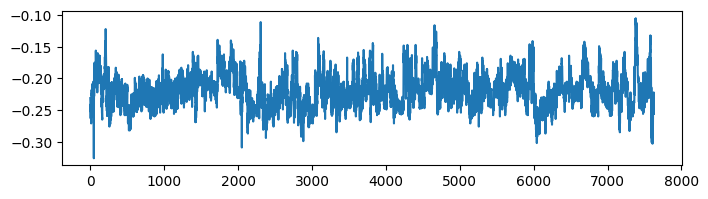

In [5]:
plt.figure(figsize=(8,2))
plt.plot(relacion_aspecto)

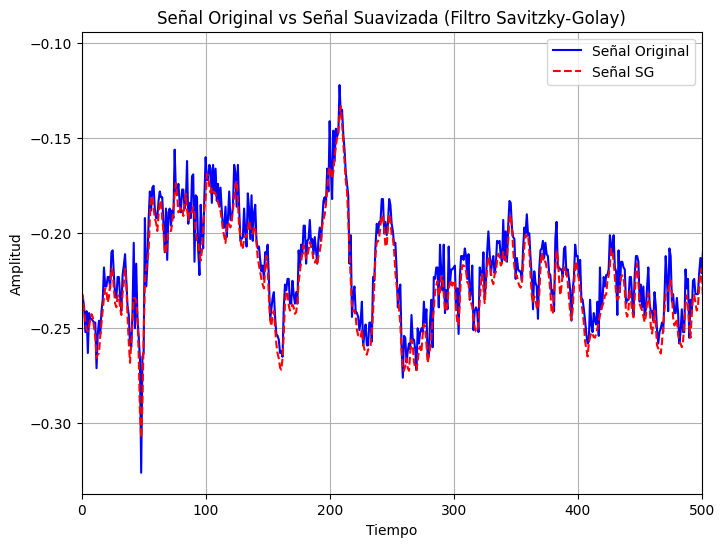

In [6]:
# Parámetros del filtro Savitzky-Golay
# 13-25

orden = 14   # Orden del polinomio
ventana = 25
filtered_signal = relacion_aspecto
# Aplicar el filtro Savitzky-Golay
señal_suavizada = savgol_filter(filtered_signal, ventana, orden)

# Crear un arreglo de índices para las muestras
indices = np.arange(len(filtered_signal))

# Crear una figura y un eje
plt.figure(figsize=(8, 6))
plt.plot(relacion_aspecto, label='Señal Original', linestyle='-', color='blue')
plt.plot(señal_suavizada, label='Señal SG', linestyle='--', color='red')

# Configurar el gráfico
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal Original vs Señal Suavizada (Filtro Savitzky-Golay)')
plt.legend()
plt.grid(True)
plt.xlim(0,500)
# Mostrar la gráfica
plt.show()

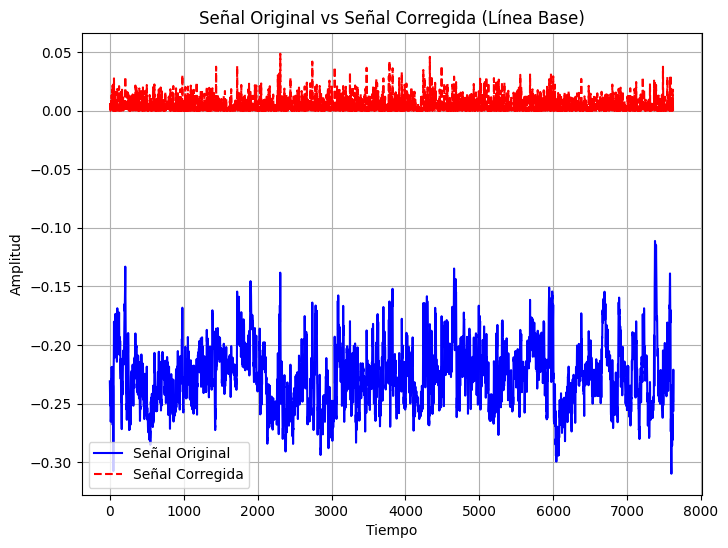

In [7]:
# Tamaño de la ventana de la media móvil
ventana = 15  # Ajusta el tamaño de la ventana según tus necesidades

filtered_signal = relacion_aspecto

# Calcular la línea base usando la media móvil
linea_base = np.convolve(señal_suavizada, np.ones(ventana)/ventana, mode='same')

# Corregir la señal restando la línea base
señal_corregida = señal_suavizada - linea_base

for i in range(0, len(señal_corregida)):
    if señal_corregida[i] < 0:
        señal_corregida[i] = 0
    
# Crear un arreglo de índices para las muestras
indices = np.arange(len(señal_suavizada))

# Crear una figura y un eje
plt.figure(figsize=(8, 6))
plt.plot(señal_suavizada, label='Señal Original', linestyle='-', color='blue')
plt.plot(señal_corregida, label='Señal Corregida', linestyle='--', color='red')

# Configurar el gráfico
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal Original vs Señal Corregida (Línea Base)')
plt.legend()
plt.grid(True)
#plt.xlim(0,500)
# Mostrar la gráfica
plt.show()

In [8]:
avg = np.std(linea_base)
avg

0.023338234524233774

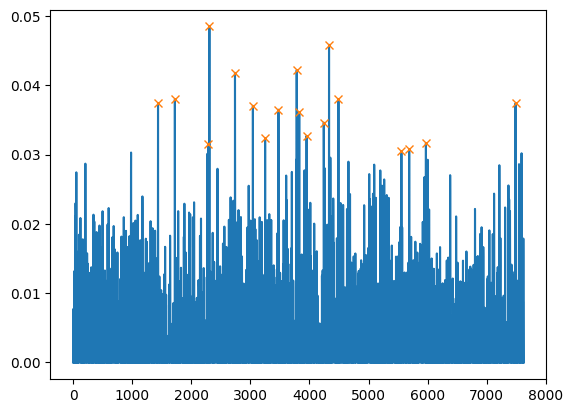

In [9]:
from scipy.signal import find_peaks, peak_widths #la funcion find_peaks
from scipy.signal import unique_roots #la funcion find_peaks

señal_final = señal_corregida 
#señal_final = np.multiply(señal_corregida, -1)
peaks, propiedades = find_peaks(señal_final, height=avg*1.3, width=1)
plt.plot(señal_final)
plt.plot(peaks, señal_final[peaks], "x")
#plt.xlim(0,500)
plt.show()


In [10]:
len(peaks)

18

In [11]:
np.multiply(peaks, 1)

array([1438, 1723, 2290, 2307, 2740, 3043, 3250, 3475, 3784, 3827, 3951,
       4242, 4331, 4490, 5555, 5687, 5970, 7486], dtype=int64)

In [13]:
propiedades['widths']

array([3.04458429, 2.95210863, 5.63972005, 3.79256421, 3.09359156,
       2.82477331, 2.7495027 , 2.96697639, 3.2625708 , 3.45451808,
       2.67802371, 5.41701077, 2.56680251, 3.64776228, 2.80847911,
       2.73257401, 2.45794543, 2.8646542 ])

In [14]:
maquina = propiedades['widths'] >= 1

In [15]:
np.count_nonzero(maquina)

18

In [16]:
picosfiltrados = peaks[maquina]
peaks[maquina]

array([1438, 1723, 2290, 2307, 2740, 3043, 3250, 3475, 3784, 3827, 3951,
       4242, 4331, 4490, 5555, 5687, 5970, 7486], dtype=int64)

In [17]:
prediccion = np.zeros(len(relacion_aspecto))

In [18]:
prueba_aspecto = np.multiply(relacion_aspecto, -1)
for i in range(0, np.count_nonzero(picosfiltrados)):
    indice = picosfiltrados[i]
    prediccion[indice] = 1

In [19]:
for i in range(0, np.count_nonzero(picosfiltrados)):
    indice = picosfiltrados[i]
    valor_maximo = indice
    while señal_final[valor_maximo] > señal_final[valor_maximo+1] :
        valor_maximo = valor_maximo +1
    valor_minimo = indice    
    while señal_final[valor_minimo] > señal_final[valor_minimo-1]:
        valor_minimo = valor_minimo - 1

    prediccion[valor_minimo:valor_maximo+1] = 1

In [20]:
datapredic = {"frameID": frame_data, "prediccion": prediccion, "Ear": np.multiply(filtered_signal, -1), "Señal_Final":señal_final}
datos = pd.DataFrame(datapredic, columns=datapredic.keys())
datos.to_csv(ruta+'predic72.csv', sep = ";", header=True, index=False,index_label='frameID')